In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

from src.model import DenseNet121
from src.utils import compute_AUCs
from src.dataset import ChestXrayDataSet, CLASS_NAMES

import torchvision
import torchvision.transforms as transforms
from torchvision.models.densenet import DenseNet121_Weights
from PIL import Image
from tqdm import tqdm

# Autoreload modules so that changes to src automatically reflect
%load_ext autoreload
%autoreload 2

In [2]:
labels = pd.read_csv("data/labels/cleaned.csv")
X, Y = labels.iloc[:, 0], labels.iloc[:, 1]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, shuffle=True, random_state=42)

In [3]:
N_CLASSES = len(CLASS_NAMES)
DATA_DIR = "images"
BATCH_SIZE = 64

In [4]:
train_dataset = ChestXrayDataSet(data_dir=DATA_DIR, X = X_train, Y = Y_train,
                          transform=transforms.Compose([
                              transforms.Resize(256),
                              transforms.ToTensor(),
                              transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225]),
                              transforms.RandomHorizontalFlip()
                              ]))

# note that workers take up some amount of VRAM   
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)

test_dataset = ChestXrayDataSet(data_dir=DATA_DIR, X = X_test, Y = Y_test,
                          transform=transforms.Compose([
                              transforms.Resize(256),
                              transforms.ToTensor(),
                              transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
                              ]))
    
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)

In [5]:
CKPT_TRAINED_PATH = "model-trained.pth"

cudnn.benchmark = True # Fixed input size, enables tuning for optimal use

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# initialize and load the model
model = DenseNet121(N_CLASSES).to(device)

if os.path.isfile(CKPT_TRAINED_PATH):
    print("=> loading checkpoint")
    checkpoint = torch.load(CKPT_TRAINED_PATH)
    # Load directly into the module else the model gets screwed up
    # https://discuss.pytorch.org/t/solved-keyerror-unexpected-key-module-encoder-embedding-weight-in-state-dict/1686/15
    model.load_state_dict(checkpoint, strict=True)
    print("=> loaded checkpoint")
else:
    print("=> no checkpoint found")

=> loading checkpoint
=> loaded checkpoint


In [6]:
# initialize the ground truth and output tensor
gt = torch.FloatTensor()
pred = torch.FloatTensor()
gt = gt.cuda()
pred = pred.cuda()

# switch to evaluate mode
model.eval()

DenseNet121(
  (densenet121): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, mome

### Generating Adversarial Examples

In [7]:
from torchattacks import PGD, FGSM, BIM, DeepFool, SparseFool, TPGD

In [8]:
def load_dataset(dataloader, n_examples):
    res_x, res_y = [], []
    for i, (x, y, _) in enumerate(dataloader):
        res_x.append(x)
        res_y.append(y)
        if n_examples is not None and BATCH_SIZE * i >= n_examples:
            break

    x_tensor = torch.cat(res_x)
    y_tensor = torch.cat(res_y)

    if n_examples is not None:
        x_tensor = x_tensor[:n_examples]
        y_tensor = y_tensor[:n_examples]

    print(x_tensor.shape, y_tensor.shape)

    return x_tensor, y_tensor

In [9]:
def get_pred(model, images, device):
    logits = model(images.to(device))
    _, pres = logits.max(dim=1)
    return pres.cpu()

def imshow(img, title):
    img = torchvision.utils.make_grid(img.cpu().data, normalize=True)
    npimg = img.numpy()
    fig = plt.figure(figsize = (5, 15))
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.title(title)
    plt.show()

In [10]:
images, labels = load_dataset(test_loader, 10)

torch.Size([10, 3, 256, 256]) torch.Size([10, 14])


### Inspecting the Adversarial Examples when they move through the network

In [131]:
# atk = PGD(model, eps=8/255, alpha=2/225, steps=10, random_start=True)
# atk = BIM(model, eps=8/255, alpha=2/255, steps=10)
# atk = FGSM(model, eps=8/255)
atk = TPGD(model, eps=8/255, alpha=2/255, steps=10)
atk.set_normalization_used(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
adv_images = atk(images, labels)

In [132]:
features = {}

def get_features(name):
    def hook(model, input, output):
        features[name] = output.detach()
    return hook

model.densenet121.features.conv0.register_forward_hook(get_features('conv0'))
model.densenet121.features.denseblock1.register_forward_hook(get_features('denseblock1'))
model.densenet121.features.denseblock2.register_forward_hook(get_features('denseblock2'))
model.densenet121.features.denseblock3.register_forward_hook(get_features('denseblock3'))
model.densenet121.features.denseblock4.register_forward_hook(get_features('denseblock4'))

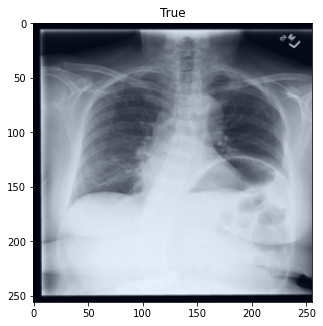

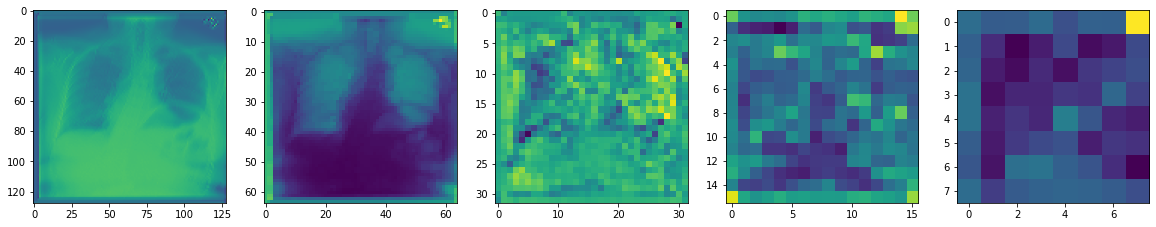

In [133]:
idx = 21
x = model(images.to(device))

imshow(images[0], "True")

fig, axs = plt.subplots(1, 5, figsize=(20, 20))

axs[0].imshow(features['conv0'][0, idx].cpu().detach().numpy())
axs[1].imshow(features['denseblock1'][0, idx].cpu().detach().numpy())
axs[2].imshow(features['denseblock2'][0, idx].cpu().detach().numpy())
axs[3].imshow(features['denseblock3'][0,idx].cpu().detach().numpy())
axs[4].imshow(features['denseblock4'][0,idx].cpu().detach().numpy())
plt.show()

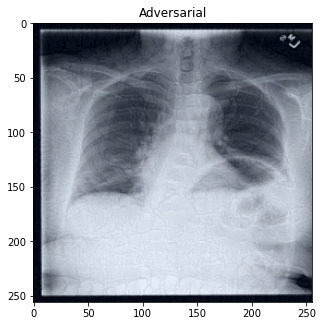

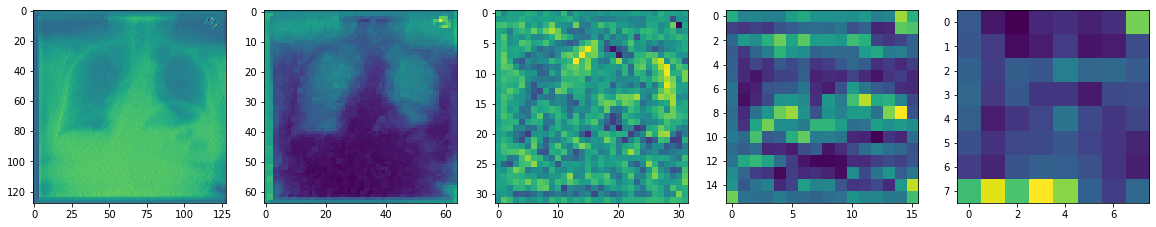

In [137]:
x = model(adv_images.to(device))

imshow(adv_images[0], "Adversarial")

fig, axs = plt.subplots(1, 5, figsize=(20, 20))

axs[0].imshow(features['conv0'][0, idx].cpu().detach().numpy())
axs[1].imshow(features['denseblock1'][0, idx].cpu().detach().numpy())
axs[2].imshow(features['denseblock2'][0, idx].cpu().detach().numpy())
axs[3].imshow(features['denseblock3'][0,idx].cpu().detach().numpy())
axs[4].imshow(features['denseblock4'][0,idx].cpu().detach().numpy())
plt.show()

Test

In [90]:
# plt.imshow(x[0, 5].cpu().detach().numpy())